# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [101]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [102]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [103]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207459e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [104]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0189654196061


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [105]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447656e-11
b1 max relative error: 2.738421e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  5.73538511945e-05


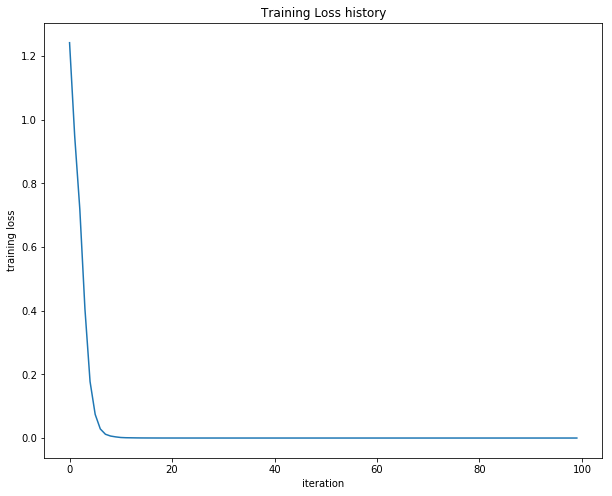

In [106]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [107]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [108]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302771
iteration 100 / 1000: loss 2.253051
iteration 200 / 1000: loss 2.030690
iteration 300 / 1000: loss 1.976257
iteration 400 / 1000: loss 1.912534
iteration 500 / 1000: loss 1.882971
iteration 600 / 1000: loss 1.764563
iteration 700 / 1000: loss 1.839365
iteration 800 / 1000: loss 1.752863
iteration 900 / 1000: loss 1.674092
Validation accuracy:  0.424


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

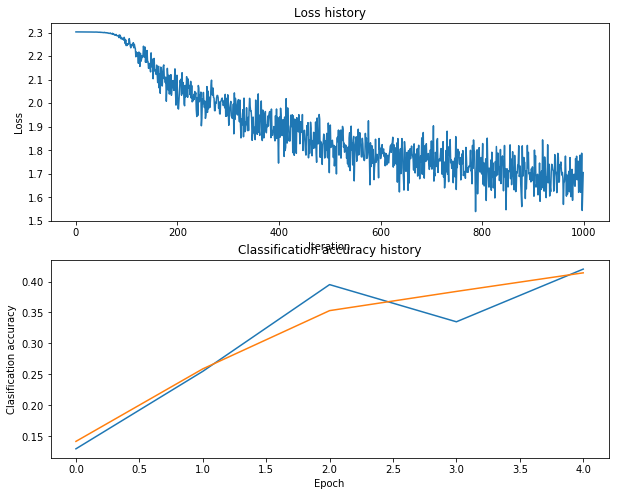

In [109]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

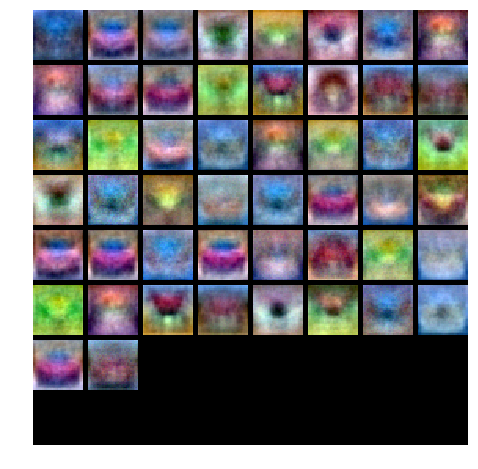

In [92]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

iteration 0 / 3000: loss 2.303124
iteration 100 / 3000: loss 2.276037
iteration 200 / 3000: loss 2.171088
iteration 300 / 3000: loss 2.084155
iteration 400 / 3000: loss 1.967320
iteration 500 / 3000: loss 1.995141
iteration 600 / 3000: loss 1.874515
iteration 700 / 3000: loss 1.869549
iteration 800 / 3000: loss 1.855925
iteration 900 / 3000: loss 1.998179
iteration 1000 / 3000: loss 1.959410
iteration 1100 / 3000: loss 1.956128
iteration 1200 / 3000: loss 1.826894
iteration 1300 / 3000: loss 1.979389
iteration 1400 / 3000: loss 1.903271
iteration 1500 / 3000: loss 1.976880
iteration 1600 / 3000: loss 1.852993
iteration 1700 / 3000: loss 1.907906
iteration 1800 / 3000: loss 1.909439
iteration 1900 / 3000: loss 1.976850
iteration 2000 / 3000: loss 2.064849
iteration 2100 / 3000: loss 1.972983
iteration 2200 / 3000: loss 2.011872
iteration 2300 / 3000: loss 2.021040
iteration 2400 / 3000: loss 1.852935
iteration 2500 / 3000: loss 1.817780
iteration 2600 / 3000: loss 2.012132
iteration 270

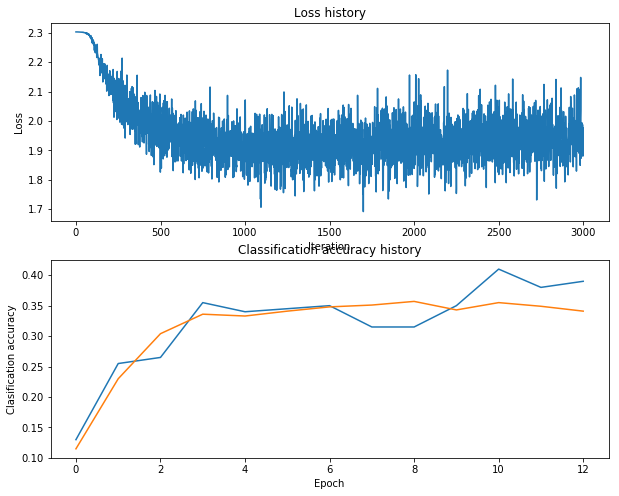

iteration 0 / 3000: loss 2.303741
iteration 100 / 3000: loss 2.270746
iteration 200 / 3000: loss 2.125535
iteration 300 / 3000: loss 2.083436
iteration 400 / 3000: loss 2.038502
iteration 500 / 3000: loss 1.963716
iteration 600 / 3000: loss 1.951323
iteration 700 / 3000: loss 1.904523
iteration 800 / 3000: loss 1.961790
iteration 900 / 3000: loss 1.913661
iteration 1000 / 3000: loss 1.966526
iteration 1100 / 3000: loss 1.933388
iteration 1200 / 3000: loss 1.891233
iteration 1300 / 3000: loss 1.919580
iteration 1400 / 3000: loss 1.863722
iteration 1500 / 3000: loss 2.023923
iteration 1600 / 3000: loss 1.915943
iteration 1700 / 3000: loss 2.025197
iteration 1800 / 3000: loss 1.913000
iteration 1900 / 3000: loss 1.892487
iteration 2000 / 3000: loss 2.167354
iteration 2100 / 3000: loss 1.969542
iteration 2200 / 3000: loss 2.039867
iteration 2300 / 3000: loss 1.978548
iteration 2400 / 3000: loss 1.790928
iteration 2500 / 3000: loss 2.061981
iteration 2600 / 3000: loss 1.912580
iteration 270

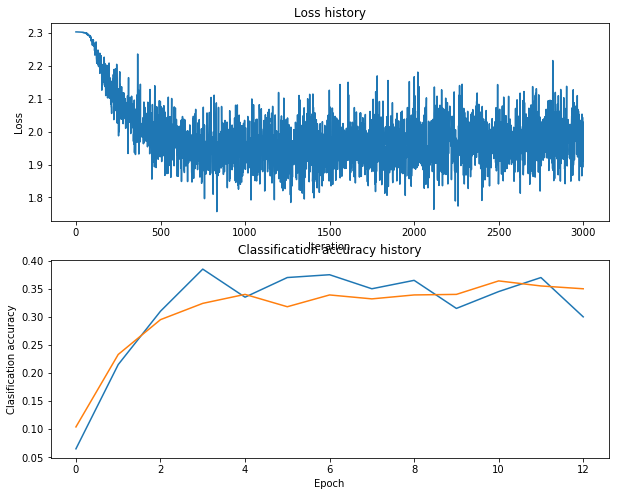

iteration 0 / 3000: loss 2.302911
iteration 100 / 3000: loss 2.286826
iteration 200 / 3000: loss 2.130276
iteration 300 / 3000: loss 1.961116
iteration 400 / 3000: loss 1.957969
iteration 500 / 3000: loss 1.912512
iteration 600 / 3000: loss 1.888311
iteration 700 / 3000: loss 1.906225
iteration 800 / 3000: loss 1.916224
iteration 900 / 3000: loss 1.908666
iteration 1000 / 3000: loss 2.025990
iteration 1100 / 3000: loss 1.793868
iteration 1200 / 3000: loss 1.869060
iteration 1300 / 3000: loss 1.859465
iteration 1400 / 3000: loss 1.862890
iteration 1500 / 3000: loss 1.932047
iteration 1600 / 3000: loss 1.883358
iteration 1700 / 3000: loss 1.899363
iteration 1800 / 3000: loss 1.903821
iteration 1900 / 3000: loss 1.797752
iteration 2000 / 3000: loss 1.804769
iteration 2100 / 3000: loss 1.978758
iteration 2200 / 3000: loss 1.910309
iteration 2300 / 3000: loss 1.851133
iteration 2400 / 3000: loss 1.888986
iteration 2500 / 3000: loss 1.968837
iteration 2600 / 3000: loss 1.920764
iteration 270

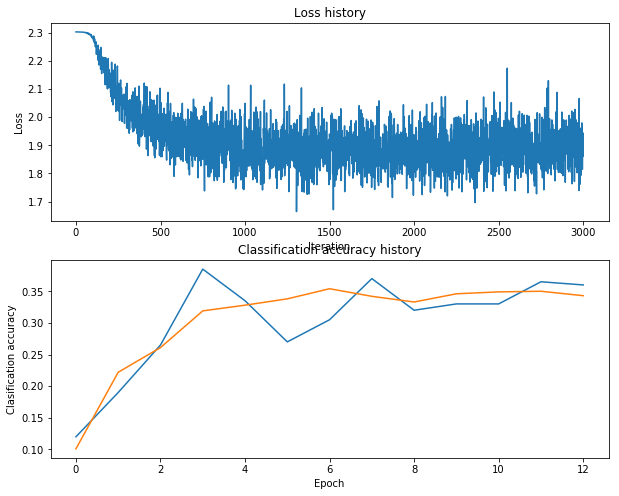

iteration 0 / 3000: loss 2.303179
iteration 100 / 3000: loss 2.154062
iteration 200 / 3000: loss 2.064575
iteration 300 / 3000: loss 2.013503
iteration 400 / 3000: loss 1.929053
iteration 500 / 3000: loss 1.984462
iteration 600 / 3000: loss 2.004617
iteration 700 / 3000: loss 1.960293
iteration 800 / 3000: loss 1.848129
iteration 900 / 3000: loss 1.846472
iteration 1000 / 3000: loss 1.924929
iteration 1100 / 3000: loss 1.904791
iteration 1200 / 3000: loss 1.939603
iteration 1300 / 3000: loss 2.017812
iteration 1400 / 3000: loss 1.987876
iteration 1500 / 3000: loss 1.992673
iteration 1600 / 3000: loss 1.942276
iteration 1700 / 3000: loss 1.954941
iteration 1800 / 3000: loss 1.966169
iteration 1900 / 3000: loss 2.066581
iteration 2000 / 3000: loss 1.925477
iteration 2100 / 3000: loss 2.128459
iteration 2200 / 3000: loss 2.023231
iteration 2300 / 3000: loss 1.994750
iteration 2400 / 3000: loss 2.059023
iteration 2500 / 3000: loss 1.994715
iteration 2600 / 3000: loss 2.085675
iteration 270

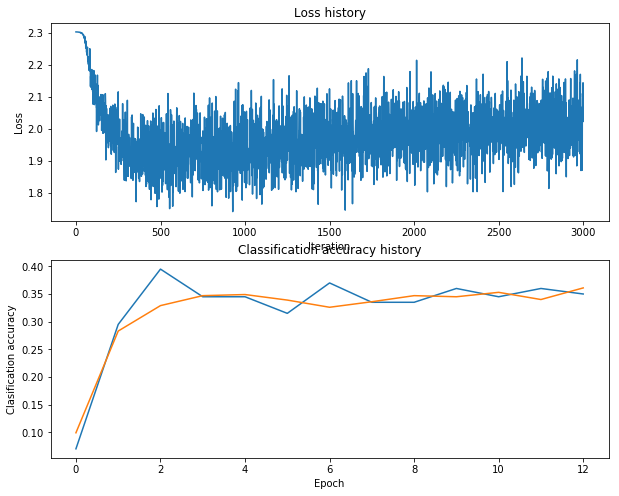

iteration 0 / 3000: loss 2.303729
iteration 100 / 3000: loss 2.216316
iteration 200 / 3000: loss 2.099644
iteration 300 / 3000: loss 1.966750
iteration 400 / 3000: loss 1.877843
iteration 500 / 3000: loss 1.939784
iteration 600 / 3000: loss 1.940005
iteration 700 / 3000: loss 1.984020
iteration 800 / 3000: loss 1.969028
iteration 900 / 3000: loss 2.036153
iteration 1000 / 3000: loss 1.975201
iteration 1100 / 3000: loss 1.994097
iteration 1200 / 3000: loss 2.095316
iteration 1300 / 3000: loss 1.989640
iteration 1400 / 3000: loss 2.014922
iteration 1500 / 3000: loss 1.989601
iteration 1600 / 3000: loss 2.035249
iteration 1700 / 3000: loss 1.932332
iteration 1800 / 3000: loss 2.196433
iteration 1900 / 3000: loss 1.997405
iteration 2000 / 3000: loss 1.957029
iteration 2100 / 3000: loss 1.985382
iteration 2200 / 3000: loss 1.964790
iteration 2300 / 3000: loss 2.087097
iteration 2400 / 3000: loss 1.938531
iteration 2500 / 3000: loss 2.028668
iteration 2600 / 3000: loss 1.889028
iteration 270

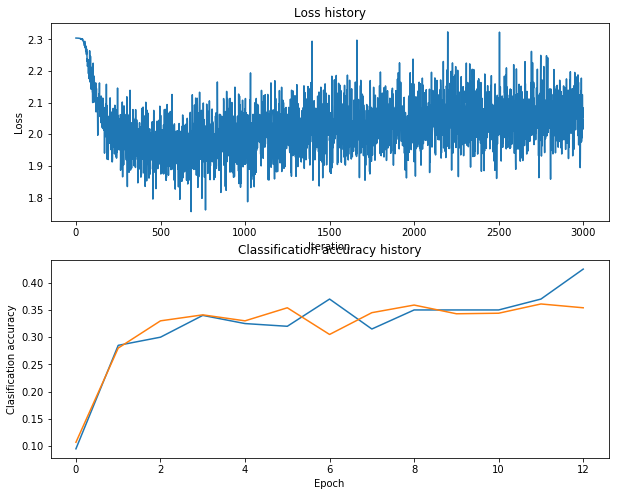

iteration 0 / 3000: loss 2.302853
iteration 100 / 3000: loss 2.057385
iteration 200 / 3000: loss 1.936480
iteration 300 / 3000: loss 1.985199
iteration 400 / 3000: loss 1.848400
iteration 500 / 3000: loss 1.912410
iteration 600 / 3000: loss 1.957168
iteration 700 / 3000: loss 1.864381
iteration 800 / 3000: loss 1.949400
iteration 900 / 3000: loss 1.955386
iteration 1000 / 3000: loss 1.859964
iteration 1100 / 3000: loss 1.856752
iteration 1200 / 3000: loss 1.965097
iteration 1300 / 3000: loss 1.932517
iteration 1400 / 3000: loss 2.114890
iteration 1500 / 3000: loss 1.962873
iteration 1600 / 3000: loss 1.912959
iteration 1700 / 3000: loss 1.820169
iteration 1800 / 3000: loss 1.970481
iteration 1900 / 3000: loss 1.960139
iteration 2000 / 3000: loss 1.938620
iteration 2100 / 3000: loss 2.011334
iteration 2200 / 3000: loss 1.977636
iteration 2300 / 3000: loss 1.915138
iteration 2400 / 3000: loss 1.942032
iteration 2500 / 3000: loss 1.900788
iteration 2600 / 3000: loss 2.077797
iteration 270

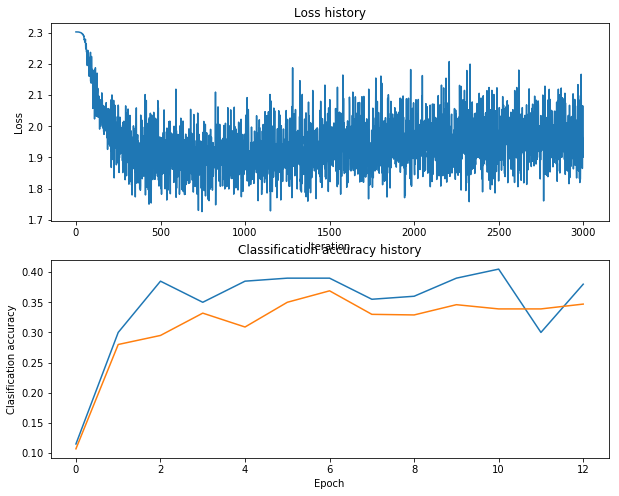

iteration 0 / 3000: loss 2.303177
iteration 100 / 3000: loss 2.120225
iteration 200 / 3000: loss 2.104062
iteration 300 / 3000: loss 1.926856
iteration 400 / 3000: loss 2.024990
iteration 500 / 3000: loss 1.924761
iteration 600 / 3000: loss 2.026166
iteration 700 / 3000: loss 2.016259
iteration 800 / 3000: loss 1.978038
iteration 900 / 3000: loss 2.133800
iteration 1000 / 3000: loss 2.032653
iteration 1100 / 3000: loss 2.156110
iteration 1200 / 3000: loss 2.059505
iteration 1300 / 3000: loss 2.000850
iteration 1400 / 3000: loss 2.108837
iteration 1500 / 3000: loss 2.034280
iteration 1600 / 3000: loss 2.157581
iteration 1700 / 3000: loss 2.069358
iteration 1800 / 3000: loss 2.155915
iteration 1900 / 3000: loss 1.986601
iteration 2000 / 3000: loss 2.014237
iteration 2100 / 3000: loss 2.035372
iteration 2200 / 3000: loss 2.114607
iteration 2300 / 3000: loss 2.151915
iteration 2400 / 3000: loss 2.166097
iteration 2500 / 3000: loss 2.082707
iteration 2600 / 3000: loss 2.034612
iteration 270

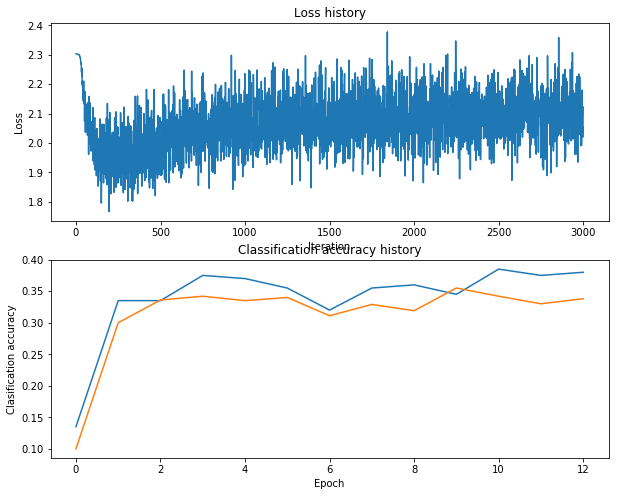

iteration 0 / 3000: loss 2.303727
iteration 100 / 3000: loss 2.053392
iteration 200 / 3000: loss 2.126972
iteration 300 / 3000: loss 2.095712
iteration 400 / 3000: loss 2.071962
iteration 500 / 3000: loss 2.100236
iteration 600 / 3000: loss 2.067862
iteration 700 / 3000: loss 1.998008
iteration 800 / 3000: loss 2.015604
iteration 900 / 3000: loss 2.052664
iteration 1000 / 3000: loss 2.055811
iteration 1100 / 3000: loss 2.068938
iteration 1200 / 3000: loss 1.962530
iteration 1300 / 3000: loss 2.048973
iteration 1400 / 3000: loss 2.098670
iteration 1500 / 3000: loss 2.046269
iteration 1600 / 3000: loss 2.097536
iteration 1700 / 3000: loss 2.031264
iteration 1800 / 3000: loss 1.977430
iteration 1900 / 3000: loss 2.209749
iteration 2000 / 3000: loss 2.122858
iteration 2100 / 3000: loss 2.114884
iteration 2200 / 3000: loss 2.049177
iteration 2300 / 3000: loss 2.123254
iteration 2400 / 3000: loss 2.119934
iteration 2500 / 3000: loss 2.142766
iteration 2600 / 3000: loss 2.165696
iteration 270

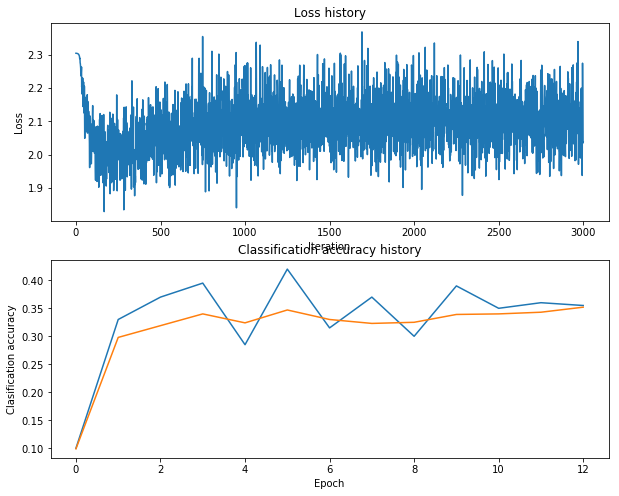

iteration 0 / 3000: loss 2.302890
iteration 100 / 3000: loss 2.050214
iteration 200 / 3000: loss 1.882355
iteration 300 / 3000: loss 1.894206
iteration 400 / 3000: loss 1.988947
iteration 500 / 3000: loss 1.963133
iteration 600 / 3000: loss 1.936986
iteration 700 / 3000: loss 2.094614
iteration 800 / 3000: loss 2.073080
iteration 900 / 3000: loss 1.875018
iteration 1000 / 3000: loss 1.927888
iteration 1100 / 3000: loss 2.045094
iteration 1200 / 3000: loss 2.121581
iteration 1300 / 3000: loss 2.066627
iteration 1400 / 3000: loss 2.073451
iteration 1500 / 3000: loss 2.035596
iteration 1600 / 3000: loss 1.912831
iteration 1700 / 3000: loss 2.018783
iteration 1800 / 3000: loss 2.129579
iteration 1900 / 3000: loss 2.167558
iteration 2000 / 3000: loss 2.064499
iteration 2100 / 3000: loss 2.140926
iteration 2200 / 3000: loss 1.923643
iteration 2300 / 3000: loss 2.058454
iteration 2400 / 3000: loss 2.016080
iteration 2500 / 3000: loss 2.262564
iteration 2600 / 3000: loss 1.967631
iteration 270

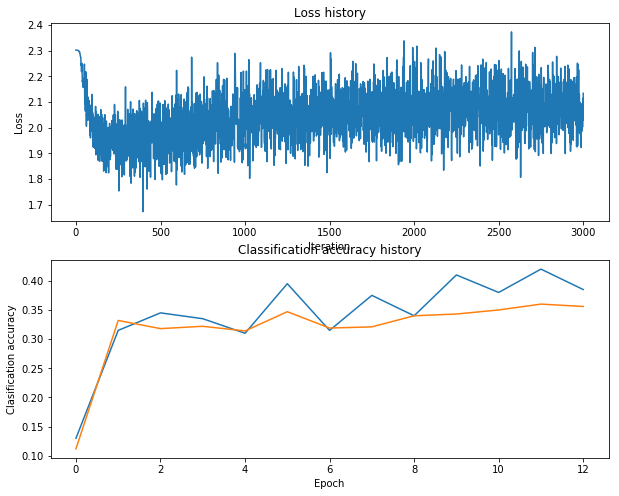

iteration 0 / 3000: loss 2.303169
iteration 100 / 3000: loss 2.073386
iteration 200 / 3000: loss 2.093790
iteration 300 / 3000: loss 2.329372
iteration 400 / 3000: loss 2.155054
iteration 500 / 3000: loss 2.063500
iteration 600 / 3000: loss 2.085929
iteration 700 / 3000: loss 2.136518
iteration 800 / 3000: loss 2.101530
iteration 900 / 3000: loss 2.166250
iteration 1000 / 3000: loss 2.323683
iteration 1100 / 3000: loss 2.109176
iteration 1200 / 3000: loss 2.264197
iteration 1300 / 3000: loss 2.289186
iteration 1400 / 3000: loss 2.163010
iteration 1500 / 3000: loss 2.233897
iteration 1600 / 3000: loss 2.237929
iteration 1700 / 3000: loss 2.095313
iteration 1800 / 3000: loss 2.238584
iteration 1900 / 3000: loss 2.296972
iteration 2000 / 3000: loss 2.323196
iteration 2100 / 3000: loss 2.328720
iteration 2200 / 3000: loss 2.042398
iteration 2300 / 3000: loss 2.024846
iteration 2400 / 3000: loss 2.131055
iteration 2500 / 3000: loss 2.195637
iteration 2600 / 3000: loss 2.097376
iteration 270

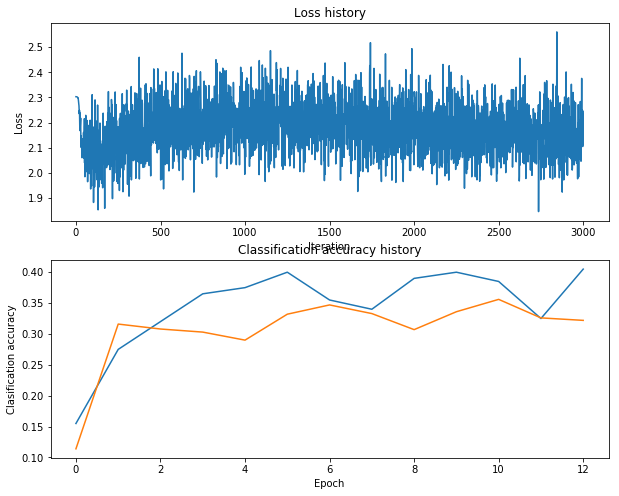

iteration 0 / 3000: loss 2.303721
iteration 100 / 3000: loss 2.111842
iteration 200 / 3000: loss 2.075894
iteration 300 / 3000: loss 2.223079
iteration 400 / 3000: loss 1.989066
iteration 500 / 3000: loss 2.099398
iteration 600 / 3000: loss 2.058462
iteration 700 / 3000: loss 2.124685
iteration 800 / 3000: loss 2.225214
iteration 900 / 3000: loss 2.082290
iteration 1000 / 3000: loss 2.161658
iteration 1100 / 3000: loss 2.123417
iteration 1200 / 3000: loss 2.198231
iteration 1300 / 3000: loss 2.245028
iteration 1400 / 3000: loss 2.137212
iteration 1500 / 3000: loss 2.114977
iteration 1600 / 3000: loss 2.009020
iteration 1700 / 3000: loss 2.278747
iteration 1800 / 3000: loss 2.101008
iteration 1900 / 3000: loss 2.225802
iteration 2000 / 3000: loss 2.142099
iteration 2100 / 3000: loss 2.312668
iteration 2200 / 3000: loss 2.150059
iteration 2300 / 3000: loss 2.156152
iteration 2400 / 3000: loss 2.319875
iteration 2500 / 3000: loss 2.107142
iteration 2600 / 3000: loss 2.294239
iteration 270

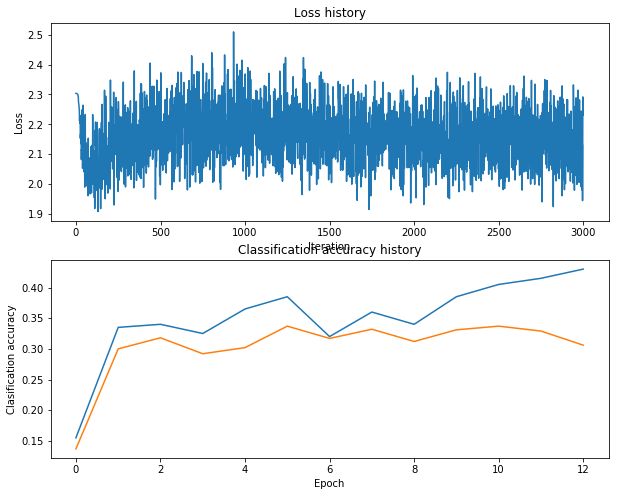

iteration 0 / 3000: loss 2.302868
iteration 100 / 3000: loss 2.075177
iteration 200 / 3000: loss 2.118993
iteration 300 / 3000: loss 2.263566
iteration 400 / 3000: loss 2.261667
iteration 500 / 3000: loss 2.049588
iteration 600 / 3000: loss 2.088924


In [ ]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

hidden_sizes = [150]
learning_rates = [1e-4, 2e-4, 5e-4, 1e-3]
regs = [0.25, 0.5, 0.125]
iter_nums = [3000]
best_acc = 0
for hs in hidden_sizes:
    for lr in learning_rates:
        for reg in regs:
            for itn in iter_nums: 
                net = TwoLayerNet(input_size, hs, num_classes)

                # Train the network
                stats = net.train(X_train, y_train, X_val, y_val,
                            num_iters=itn, batch_size=200,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val) == y_val).mean()
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_net = net
                print('Validation accuracy: ', val_acc)
                plt.subplot(2, 1, 1)
                plt.plot(stats['loss_history'])
                plt.title('Loss history')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')

                plt.subplot(2, 1, 2)
                plt.plot(stats['train_acc_history'], label='train')
                plt.plot(stats['val_acc_history'], label='val')
                plt.title('Classification accuracy history')
                plt.xlabel('Epoch')
                plt.ylabel('Clasification accuracy')
                plt.show()
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

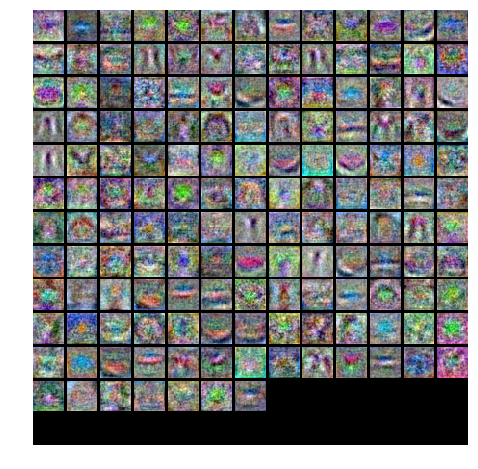

In [77]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [78]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.526
